In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import autograd.numpy as np_   # Thinly-wrapped version of Numpy
from autograd import grad


##### leitura do dataframe e remover os NaN

In [54]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df = df[df['bmi'].notna()]

# Árvore

### Sem Poda do DATAFRAME

##### df de features e df de outcomes

In [55]:
df_features = df[['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status']]
df_features = pd.get_dummies(df_features)
df_outcome = df[['stroke']]
df_outcome = df_outcome.replace(0,-1)
df_outcome = pd.get_dummies(df_outcome)

##### df de treino e df de teste

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_outcome, train_size=0.5)

##### montando o predidor de árvore e estimando valores

In [57]:
tree = DecisionTreeClassifier(criterion='entropy')
tree = tree.fit(X_train, y_train)

y_estimado = tree.predict(X_test)

##### calculando a acurácia do nosso predidor

In [58]:
accur = accuracy_score(y_estimado,y_test)
accur

0.9262729124236253

##### hipotese nula (acurácia de um predidor que só chuta -1 (sem stroke))

In [59]:
y_so_0 = np.array([-1 for i in range(len(y_estimado))])
accur_0 = accuracy_score(y_so_0,y_test)
accur_0

0.9588594704684318

##### fatores que mais provavelmente estão ligados a ter AVCs

In [60]:
importances = tree.feature_importances_
importances_indices = np.argsort(importances)[::-1]
importances_indices = importances_indices[:5]

colunas = list(df_features.head(0))

for i in range(5):
    print(colunas[importances_indices[i]])

age
avg_glucose_level
bmi
smoking_status_formerly smoked
heart_disease


##### árvore sem poda

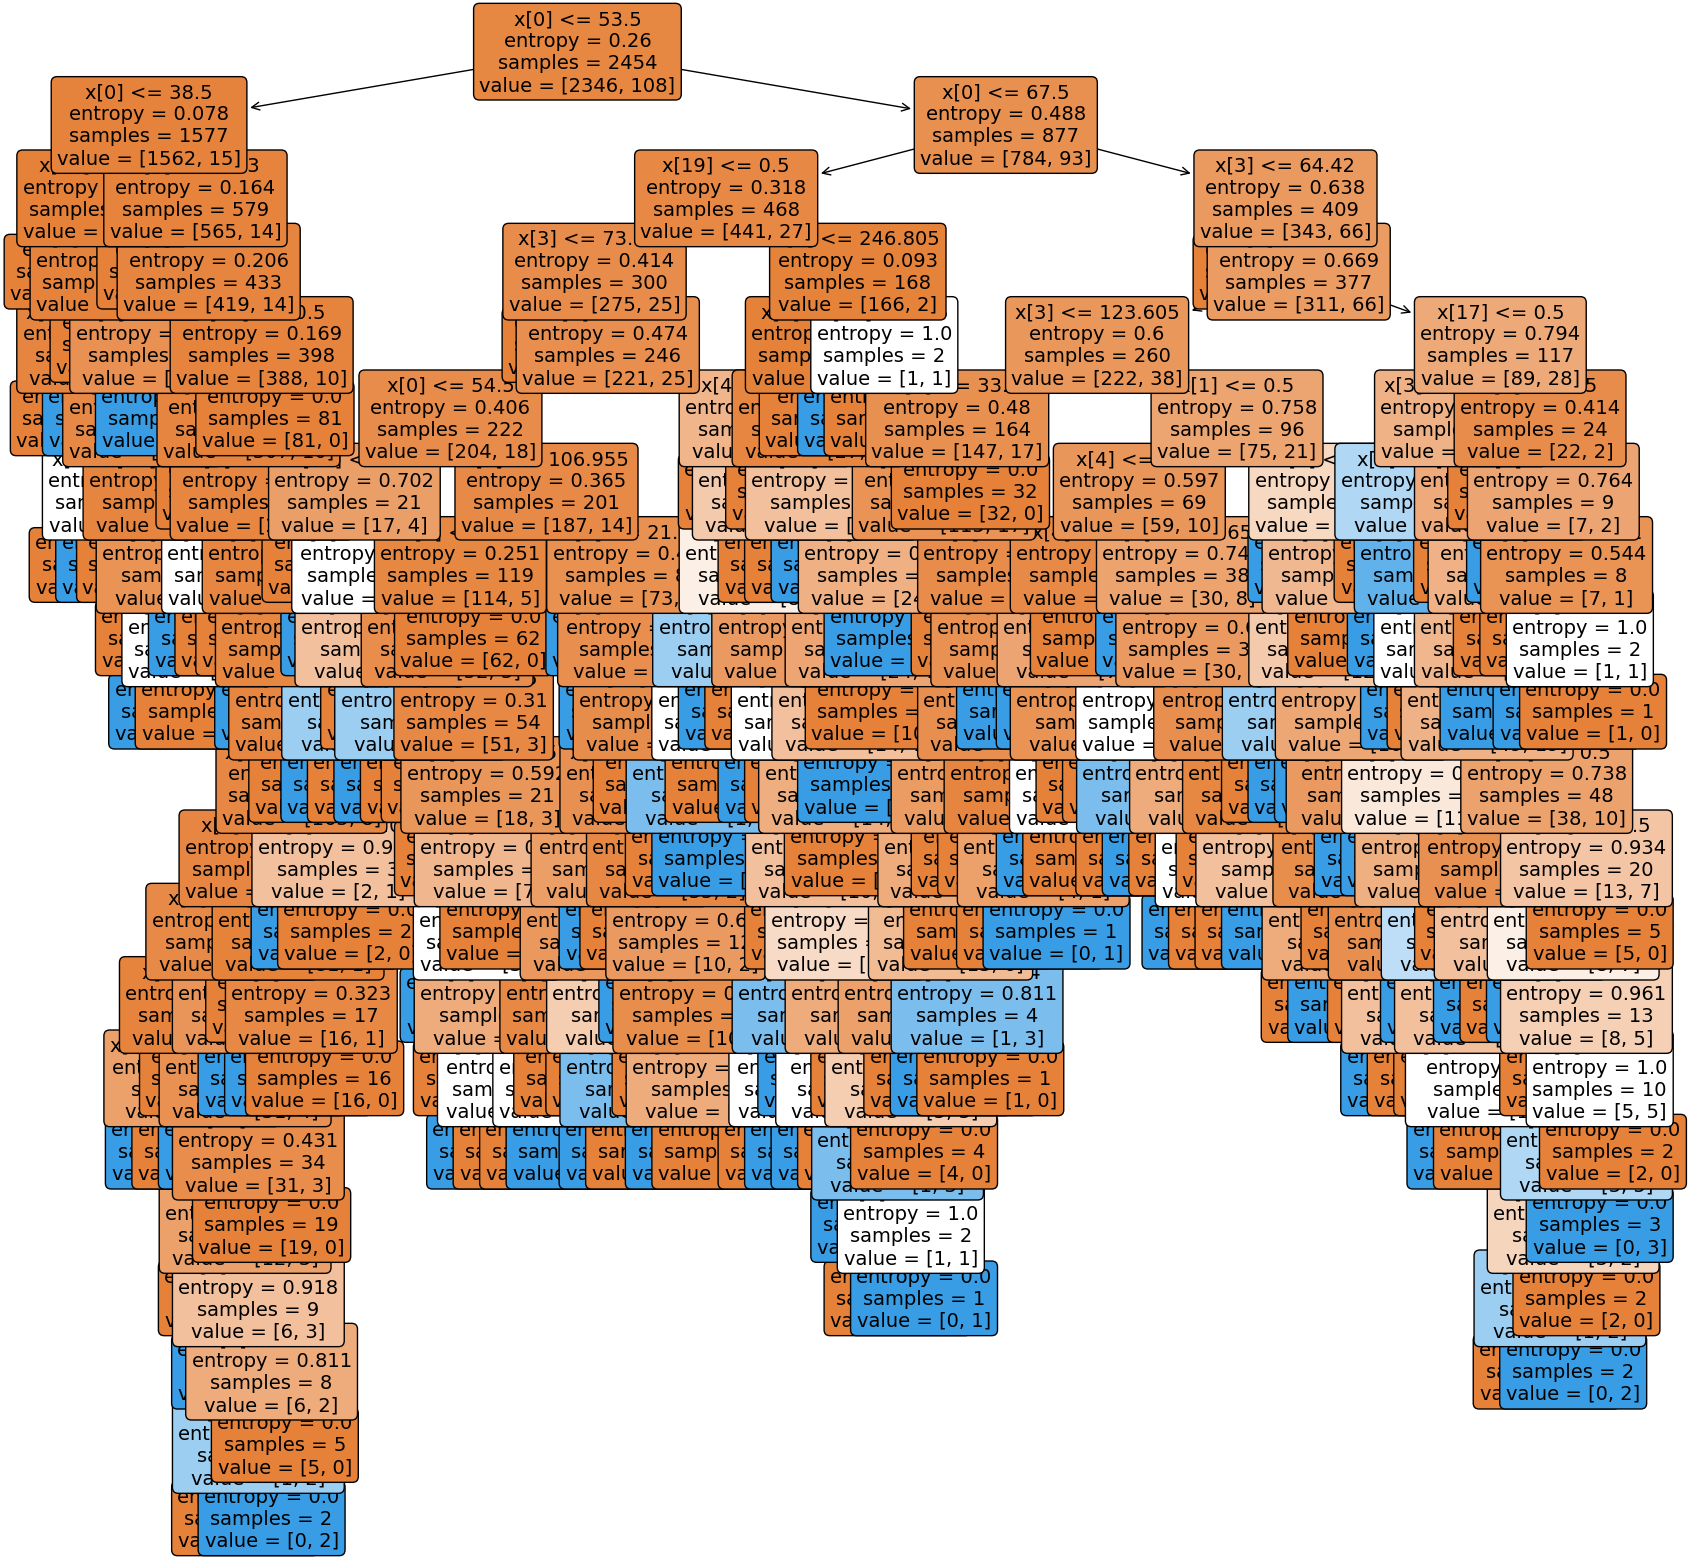

In [61]:
# plt.figure(figsize=(20, 20))
# plot_tree(tree, filled=True, rounded=True, fontsize=14)
# plt.show()

### Com poda do DATAFRAME (balancemaento de dados para strokes e para não strokes)

##### podando o dataframe (dx mesma qntd de dados de avc e não avc)

In [62]:
df_p = pd.concat([df[df['stroke'] == 0].head(len(df[df['stroke'] == 1])), df[df['stroke'] == 1]])

##### df de features e df de outcomes

In [63]:
df_features = df_p[['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status']]
df_features = pd.get_dummies(df_features)
df_outcome = df_p[['stroke']].replace(0,-1)
df_outcome = pd.get_dummies(df_outcome)

##### df de treino e df de teste

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_outcome, train_size=0.5)
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

##### montando o predidor de árvore e estimando valores

In [65]:
tree = DecisionTreeClassifier(criterion='entropy')
tree = tree.fit(X_train, y_train)

y_estimado = tree.predict(X_test)

##### calculando a acurácia do nosso predidor com poda

In [66]:
accur = accuracy_score(y_estimado,y_test)
accur

0.6124401913875598

##### hipotese nula (acurácia de um predidor que só chuta -1 (sem stroke))

In [67]:
y_so_0 = np.array([-1 for i in range(len(y_estimado))])
accur_0 = accuracy_score(y_so_0,y_test)
accur_0

0.41148325358851673

##### fatores que mais provavelmente estão ligados a ter AVCs

In [68]:
importances = tree.feature_importances_
importances_indices = np.argsort(importances)[::-1]
importances_indices = importances_indices[:5]

colunas = list(df_features.head(0))

for i in range(5):
    print(colunas[importances_indices[i]])

age
bmi
avg_glucose_level
ever_married_No
gender_Male


# Regressão Linear

Nesta etapa abaixo, ocorre a implementação de um algoritmo de treinamento por meio de regressão linear utilizando gradiente descendente para encontrar os valores ótimos dos parâmetros w (vetor de pesos) e b (bias).

A primeira função utilizada pelo algoritmo é a "loss". Esse método recebe de um conjunto de parâmetros w, b e pontos para calcular um Y estimado, ou seja, gerar um previsão. Isso occore por meio de um cálculo semelhante a uma função de primeiro grau, sendo w um vetor de coefientes ângulares e b um coeficiente linear. Logo após gerar uma previsão, utiliza o parametro val para calcular o MSE: Média dos erros quadráticos entre previsão e valor alvo. Por fim, retorna esse MSE.

A função "grad" é usada para calcular o gradiente da função loss em relação aos parâmetros w e b. O gradiente é uma medida da inclinação da função de perda em relação aos parâmetros do modelo. O gradiente nos fornece a direção na qual a função de perda está aumentando mais rapidamente. No caso do gradiente descendente, usamos essa informação para atualizar os parâmetros do modelo na direção oposta ao gradiente, de modo que a função de perda seja minimizada.

Define-se o conjunto de treinamento X e os valores alvo Y. O vetor de pesos w é inicializado aleatoriamente, e o bias b é definido como 0.5. O valor do hiperparâmetro alpha é definido como 10^-5.

Em seguida, o código entra em um loop de treinamento, que executa o gradiente descendente por 10000 iterações. Em cada iteração, o gradiente da função loss é calculado com os parâmetros atuais (w, b, X, Y) usando a função grad, para assim, atualizar os pesos w e o bias b usando o resultado do gradiente e o valor de alpha.

Por fim, calcula-se as previsões y_est para o conjunto X teste usando os valores finais dos parâmetros w e b. Em seguida, a acurácia das previsões é calculada usando a função accuracy, por meio da proporção entre previsões certas e erradas.

In [69]:
'''Extração e Tratamento dos dados. Foram levados em consideração apenas os dados capazer de serem transformados em booleanos'''

df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df = df[df['bmi'].notna()]
df = pd.concat([df[df['stroke'] == 0].head(len(df[df['stroke'] == 1])), df[df['stroke'] == 1]])

df_features = df[['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']]
df_features = pd.get_dummies(df_features)
df_outcome = df[['stroke']]
df_outcome = df_outcome.replace(0,-1)
df_outcome = pd.get_dummies(df_outcome)

X_train, X_test, y_train, y_test = train_test_split(df_features, df_outcome, train_size=0.5)
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [70]:
def accuracy(y_test, y_est):
    '''Função que calcula a precisão de um modelo de classificação binária.'''
    return np.mean(np.sign(y_test)==np.sign(y_est))

In [71]:
def loss(parametros):
    w, b, pontos, val = parametros
    est = w.T @ pontos + b
    mse = np_.mean((est - val)**2)
    return mse

g = grad(loss)

X = (X_train.T).astype(float)
Y = y_train.astype(float)

w = np.random.randn(X.shape[0],1)
b = 0.1
alpha = 10**-5

for n in range(10000):
    grad_ = g((w, b, X, Y))
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]

y_est = w.T @ X + b
pred = accuracy(y_test, y_est)

In [72]:
print(f"Acurácia do modelo com regressão linear: {pred*100:.2f}%")
print(f"Acurácia da hipótese nula: {accur_0*100:.2f}%")

Acurácia do modelo com regressão linear: 49.24%
Acurácia da hipótese nula: 41.15%


Em nossos testes, o desempenho do algoritmo de predição treinado por meio de regressão linear ficou próximo dos 50% de acurácia, semelhantemente ao resultado encotrado pela hipótese nula. 

##### fatores que mais provavelmente estão ligados a ter AVCs

In [73]:
X = pd.DataFrame(X)
mais_imp = []
for i in range(5):
    mais_imp.append(X.columns[np.argsort(w.T)[0][-i]])

colunas = list(df_features.head(0))

for i in range(5):
    print(colunas[mais_imp[i]])

Residence_type_Urban
work_type_Govt_job
heart_disease
work_type_Self-employed
smoking_status_Unknown
